In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn

%matplotlib inline

D:\Anaconda3(4.2.0)\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]

In [4]:
train_df =pd.read_csv("data/train.csv", parse_dates=['timestamp'])
test_df =pd.read_csv("data/test.csv", parse_dates=['timestamp'])
#macro_df =pd.read_csv("data/macro.csv", parse_dates=['timestamp'], usecols=['timestamp']
                     #+ macro_cols)

In [ ]:
print(train_df.shape)
print(macro_df.shape)
print(test_df.shape)

In [5]:
ylog_train_all =np.log1p(train_df['price_doc'].values)
id_test =test_df['id']

train_df.drop(['id', 'price_doc'], axis=1, inplace=True)
test_df.drop(['id'], axis=1, inplace=True)

num_train =len(train_df)
all_df =pd.concat([train_df, test_df])
#all_df =pd.merge(all_df, macro_df, on='timestamp', how='left',sort=True)
all_df.shape

(38133, 290)

In [6]:
# Add month-year
month_year = (all_df.timestamp.dt.month + all_df.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
all_df['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (all_df.timestamp.dt.weekofyear + all_df.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
all_df['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
all_df['month'] = all_df.timestamp.dt.month
all_df['dow'] = all_df.timestamp.dt.dayofweek

# Other feature engineering
all_df['rel_floor'] = all_df['floor'] / all_df['max_floor'].astype(float)
all_df['rel_kitch_sq'] = all_df['kitch_sq'] / all_df['full_sq'].astype(float)

# Remove timestamp column (may overfit the model in train)
all_df.drop(['timestamp'], axis=1, inplace=True)

In [7]:
# Deal with categorical values
df_numeric = all_df.select_dtypes(exclude=['object'])
df_obj = all_df.select_dtypes(include=['object']).copy()

for c in df_obj:
    lbl =sklearn.preprocessing.LabelEncoder()
    lbl.fit(list(df_obj[c].values))
    df_obj[c] =lbl.transform(list(df_obj[c].values))
    #df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

In [8]:
# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

# Create a validation set, with last 20% of data
num_val = int(num_train * 0.2)

X_train_all = X_all[:num_train]
X_train = X_all[:num_train-num_val]
X_val = X_all[num_train-num_val:num_train]
ylog_train = ylog_train_all[:-num_val]
ylog_val = ylog_train_all[-num_val:]

X_test = X_all[num_train:]

df_columns = df_values.columns

print('X_train_all shape is', X_train_all.shape)
print('X_train shape is', X_train.shape)
print('y_train shape is', ylog_train.shape)
print('X_val shape is', X_val.shape)
print('y_val shape is', ylog_val.shape)
print('X_test shape is', X_test.shape)

(38133, 295)
X_train_all shape is (30471, 295)
X_train shape is (24377, 295)
y_train shape is (24377,)
X_val shape is (6094, 295)
y_val shape is (6094,)
X_test shape is (7662, 295)


In [9]:
dtrain_all = xgb.DMatrix(X_train_all, ylog_train_all, feature_names=df_columns)
dtrain = xgb.DMatrix(X_train, ylog_train, feature_names=df_columns)
dval = xgb.DMatrix(X_val, ylog_val, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

In [10]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:14.4774
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:5.28048
[40]	val-rmse:1.99803
[60]	val-rmse:0.872591
[80]	val-rmse:0.5389
[100]	val-rmse:0.458506
[120]	val-rmse:0.437439
[140]	val-rmse:0.430886
[160]	val-rmse:0.428566
[180]	val-rmse:0.427719
[200]	val-rmse:0.427163
[220]	val-rmse:0.426815
[240]	val-rmse:0.426614
Stopping. Best iteration:
[237]	val-rmse:0.426596



In [ ]:
train[train.life_sq > train.full_sq].index

train[train.life_sq < 5].index

train[train.full_sq < 5].index

train[train.kitch_sq >= train.life_sq].index

train[train.build_year < 1500].index

train[train.build_year > 2017].index

train[train.state ==33].index

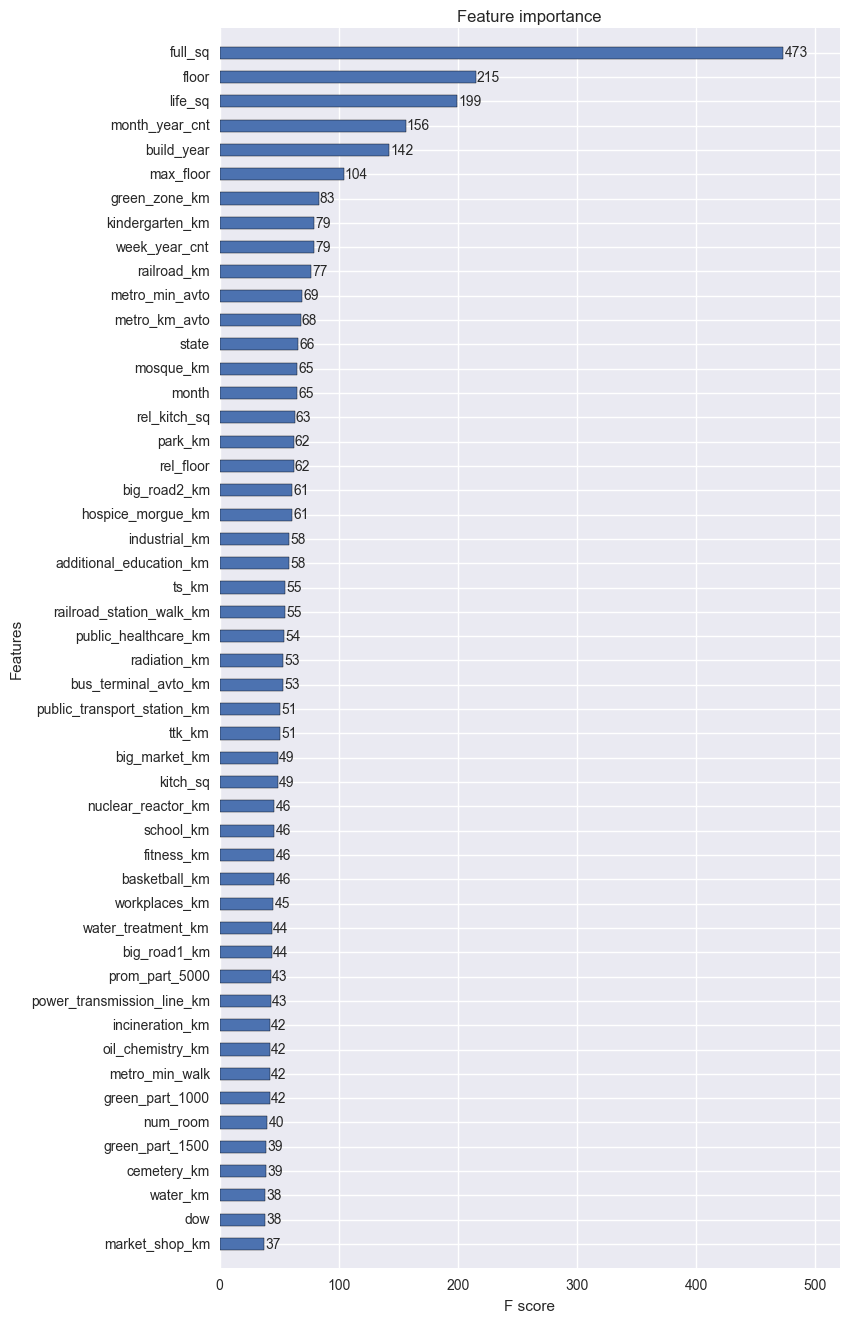

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(partial_model, height=0.5, ax=ax, max_num_features=50)

In [12]:
num_boost_round = partial_model.best_iteration
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

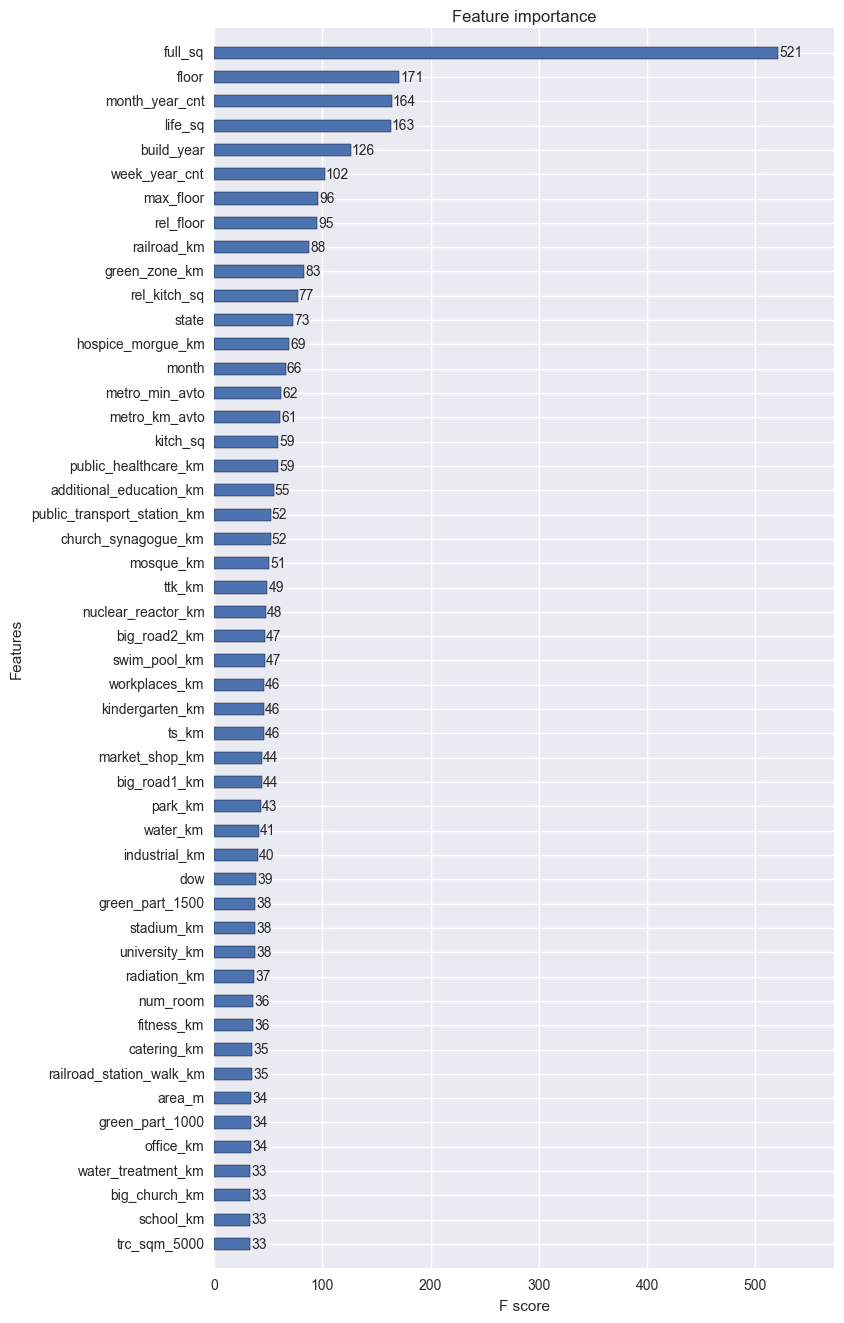

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, height=0.5, ax=ax, max_num_features=50)

In [14]:
ylog_pred = model.predict(dtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

df_sub.to_csv('sub.csv', index=False)